# Set overall settings

In [2]:
# Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd
from scipy import stats

In [3]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-white")
# plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = 'Arial'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['grid.color'] = 'white'

In [4]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            if t >= it*p+(p/2) and t < maxs/slope_off+(p)/2+p*it:
                return -slope_off*(t-it*p)+maxs+slope_off*p/2
            else:
                return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            if t >= p and t < maxs/slope_off+(p):
                return -slope_off*(t)+maxs+slope_off*p
            else:
                return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

# Figure 2
## Figure 2A - Western quantification

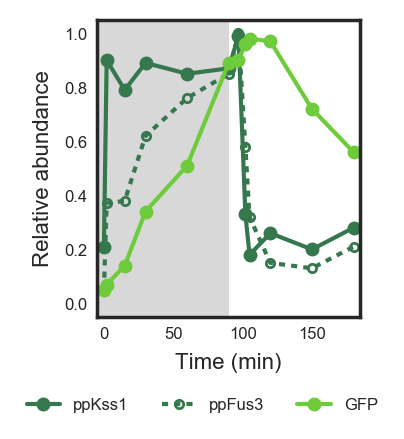

In [5]:
# plot
ppKss1 = [0.21,0.90,0.79,0.89,0.85,0.87,0.99,0.33,0.18,0.26,0.20,0.28]
ppFus3 = [0.05,0.37,0.38,0.62,0.76,0.85,1.00,0.58,0.32,0.15,0.13,0.21]
GFP = [0.05,0.07,0.14,0.34,0.51,0.89,0.90,0.96,0.98,0.97,0.72,0.56]
time = [0,2,15,30,60,90,97,102,105,120,150,180]
fig = plt.figure(figsize=(1.7,1.9685))
plt.plot(time,ppKss1,color=(54/255,120/255,77/255),marker='o',markersize=4)
plt.plot(time,ppFus3,color=(54/255,120/255,77/255),marker='o',markersize=3,linestyle=':',markerfacecolor='None',markeredgewidth=1)
plt.plot(time,GFP,color='xkcd:apple',marker='o',markersize=4)
plt.xlabel('Time (min)')
plt.ylabel('Relative abundance')
plt.fill_between([-5,90], -5, 1.2, facecolor='gray', alpha=0.3)
plt.xlim([-5,185])
plt.ylim([-0.05,1.05])
lgd = plt.legend(['ppKss1','ppFus3','GFP'],loc='upper center', bbox_to_anchor=(0.4, -0.22),ncol=3)
plt.savefig('2A.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2B - Memory vs. Pulse Length

In [6]:
# Single pulse data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/singlepulse.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
single_time, single_data = syntheticdata

In [7]:
# Calculate memory
maxindex = []
memory = []
pulse = [45,60,75,90,160]
for i,n in enumerate(single_data[1:6]):
    maxindex.append(n.index(max(n))*5)
    memory.append(n.index(max(n))*5-pulse[i])

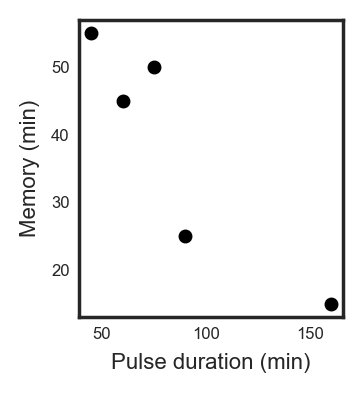

In [8]:
# Plot
fig = plt.figure(figsize=(1.7,1.9685))
plt.plot(pulse,memory,'ko',markersize=4)
plt.xlabel('Pulse duration (min)')
plt.ylabel('Memory (min)')
plt.savefig('2B.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2D

In [9]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [10]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Linear Model/180321_LinearPeriodicV2_100g500i10m50c/'
arr_best_scores, arr_end_scores, arr_best_inds=load_data(directory,1.055)
arrT_best_inds = arr_best_inds.transpose()

Loaded 25 files (out of 411) with cutoff score of 1.055


In [11]:
def signal(signal_number,t,slope_on,slope_off):
    p = signal_number
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            return 1
        else:
            return 0
def DE(y,t,signal_number,slope_on,slope_off):
    X1,X2,X3,X4 = y
        
    s=signal(signal_number,t,slope_on,slope_off)
        
    # X1
    dX1dt = s-d1*X1
    # X2
    dX2dt = k1*X1-d2*X2
    # X3
    dX3dt = k2*X2-d3*X3
    # X4
    dX4dt = k3*X3-d4*X4
        
    return [dX1dt,dX2dt,dX3dt,dX4dt]
            
def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    k1, k2, k3, d1, d2, d3, d4 = arr_parameters
    #solve odes:
    odes = odeint(DE, SS, time, args=(signal_val,1,1,))
    # return array of individual cell counts:
    return odes

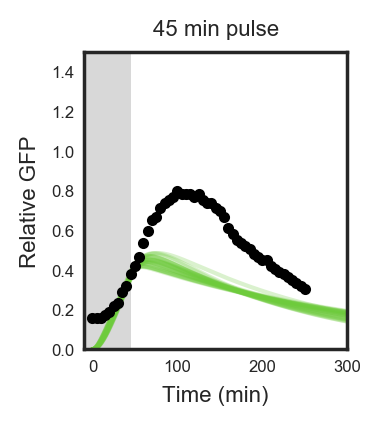

In [12]:
# plot
gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)
fig = plt.figure(figsize=(1.7,1.9685))
for j in range(len(arr_best_inds[:,gen])):
    for i in range(1):
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, 45,SS)
        plt.plot(t1,expX[:,3],color='xkcd:apple',alpha=0.25)
plt.plot(single_time[1],single_data[1],'ko',markersize = 3)
plt.title('45 min pulse')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.ylim([0,1.5])
plt.xlim([-10,300])
plt.fill_between([-10,45], -0, 1.5, facecolor='gray', alpha=0.3)
plt.savefig('2D.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2E

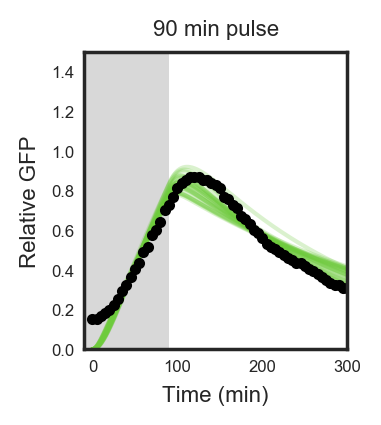

In [13]:
# plot
gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)
fig = plt.figure(figsize=(1.7,1.9685))
for j in range(len(arr_best_inds[:,gen])):
    for i in range(1):
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, 90,SS)
        plt.plot(t1,expX[:,3],color='xkcd:apple',alpha=0.25)
plt.plot(single_time[4],single_data[4],'ko',markersize = 3)
plt.title('90 min pulse')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.ylim([0,1.5])
plt.xlim([-10,300])
plt.fill_between([-10,90], -0, 1.5, facecolor='gray', alpha=0.3)
plt.savefig('2E.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2F

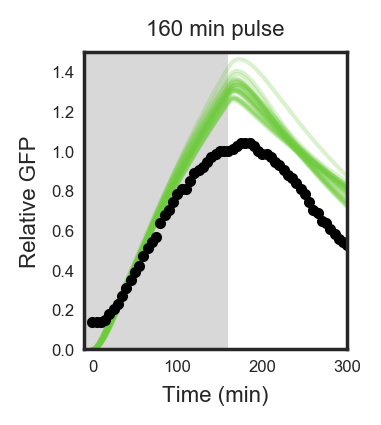

In [14]:
# plot
gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)
fig = plt.figure(figsize=(1.7,1.9685))
for j in range(len(arr_best_inds[:,gen])):
    for i in range(1):
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, 160,SS)
        plt.plot(t1,expX[:,3],color='xkcd:apple',alpha=0.25)
plt.plot(single_time[5],single_data[5],'ko',markersize = 3)
plt.title('160 min pulse')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.ylim([0,1.5])
plt.xlim([-10,300])
plt.fill_between([-10,160], -0, 1.5, facecolor='gray', alpha=0.3)
plt.savefig('2F.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Figure S1

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


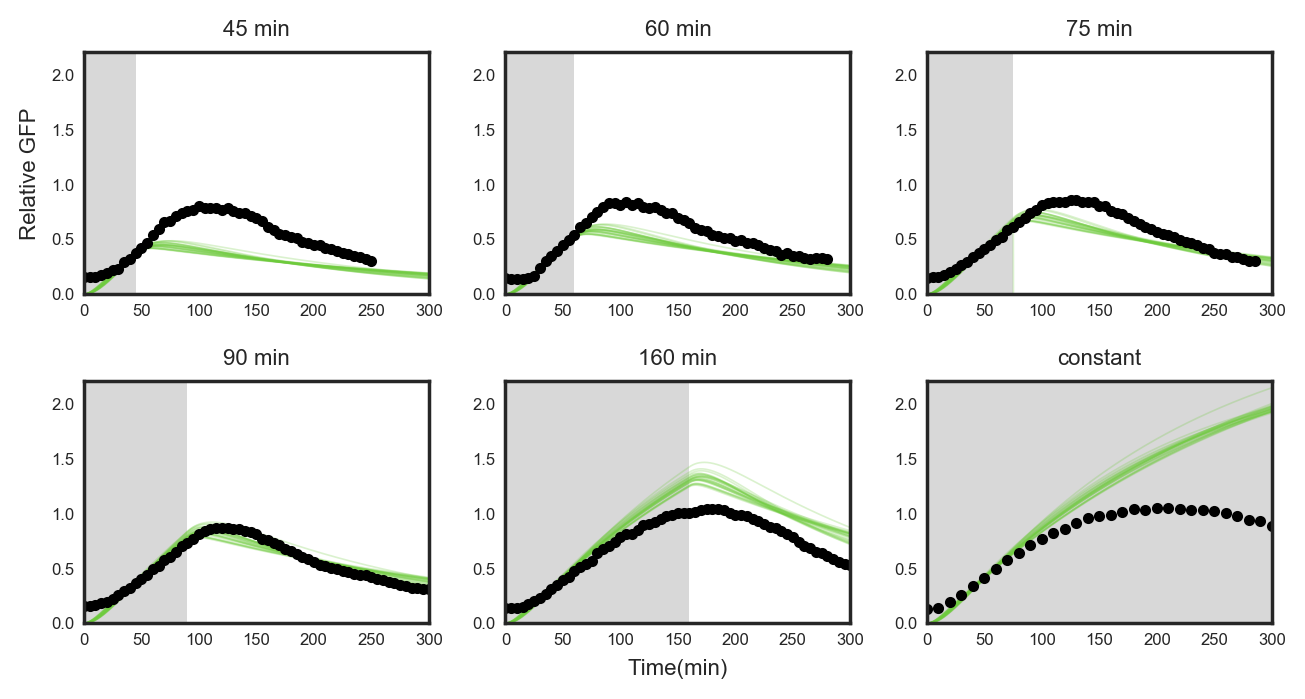

In [15]:
# Plot figure
fig = plt.figure(figsize=(6.85039, 3.75))
gs = gridspec.GridSpec(2,3)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])
D = fig.add_subplot(gs[1,0])
E = fig.add_subplot(gs[1,1])
F = fig.add_subplot(gs[1,2])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT

gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)

for j in range(len(arr_best_inds[:,gen])):
    for i in [45,60,75,90,160,1]:
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, i,SS)
        if i == 45:
            A.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 60: 
            B.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 75: 
            C.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 90:
            D.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 160:
            E.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 1:
            F.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)

scorefxn_time = single_time
scorefxn_data = single_data
A.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=3)
A.axis([0, 300, 0, 2.2])
B.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=3)
B.axis([0, 300, 0, 2.2])
C.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=3)
C.axis([0, 300, 0, 2.2])
D.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=3)
D.axis([0, 300, 0, 2.2])
E.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=3)
E.axis([0, 300, 0, 2.2])
F.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=3)
F.axis([0, 300, 0, 2.2])


for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    E.fill_between([i*240,i*240+160], 0, 2.2, facecolor='gray', alpha=0.3)

F.fill_between([0,570], 0, 2.2, facecolor='gray', alpha=0.3)
    
A.set_ylabel('Relative GFP')
ax.set_xlabel('Time(min)')

A.set_title('45 min')
B.set_title('60 min')
C.set_title('75 min')
D.set_title('90 min')
E.set_title('160 min')
F.set_title('constant')
gs.tight_layout(fig)

plt.savefig('Figure S1.pdf',dpi=600)

# Figure 3
## Figure 3C - Error vs. Generation

In [21]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Longleaf/190521_AllData_5g5i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,200)
arrT_best_inds_P = arr_best_inds_P.transpose()
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181230_TwoMutants_100g500i10m50c/'
# arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,1.6)
# arrT_best_inds_P = arr_best_inds_P.transpose()

Loaded 6 files (out of 20) with cutoff score of 200


In [22]:
# Set color scheme to match figure
fig3 = ["#939598","#336667", "#5391B3", "#B492B1", "#BD9F8D", "#75AF7E", "#AADBDC"]
sns.set_palette(fig3)
# sns.palplot(sns.color_palette())

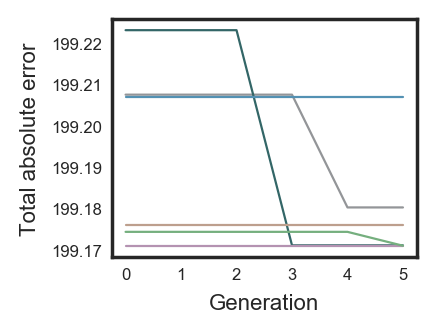

In [24]:
# plot
gen = 5
fig = plt.figure(figsize=(1.9685,1.5748))
for i in range(len(arr_best_scores_P)):
    plt.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1],linewidth=0.8)
plt.xlabel('Generation')
plt.ylabel('Total absolute error')
plt.savefig('3C.png',dpi=600,bbox_inches='tight')

# Figure 4

In [25]:
# Periodic data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic_time, periodic_data = syntheticdata

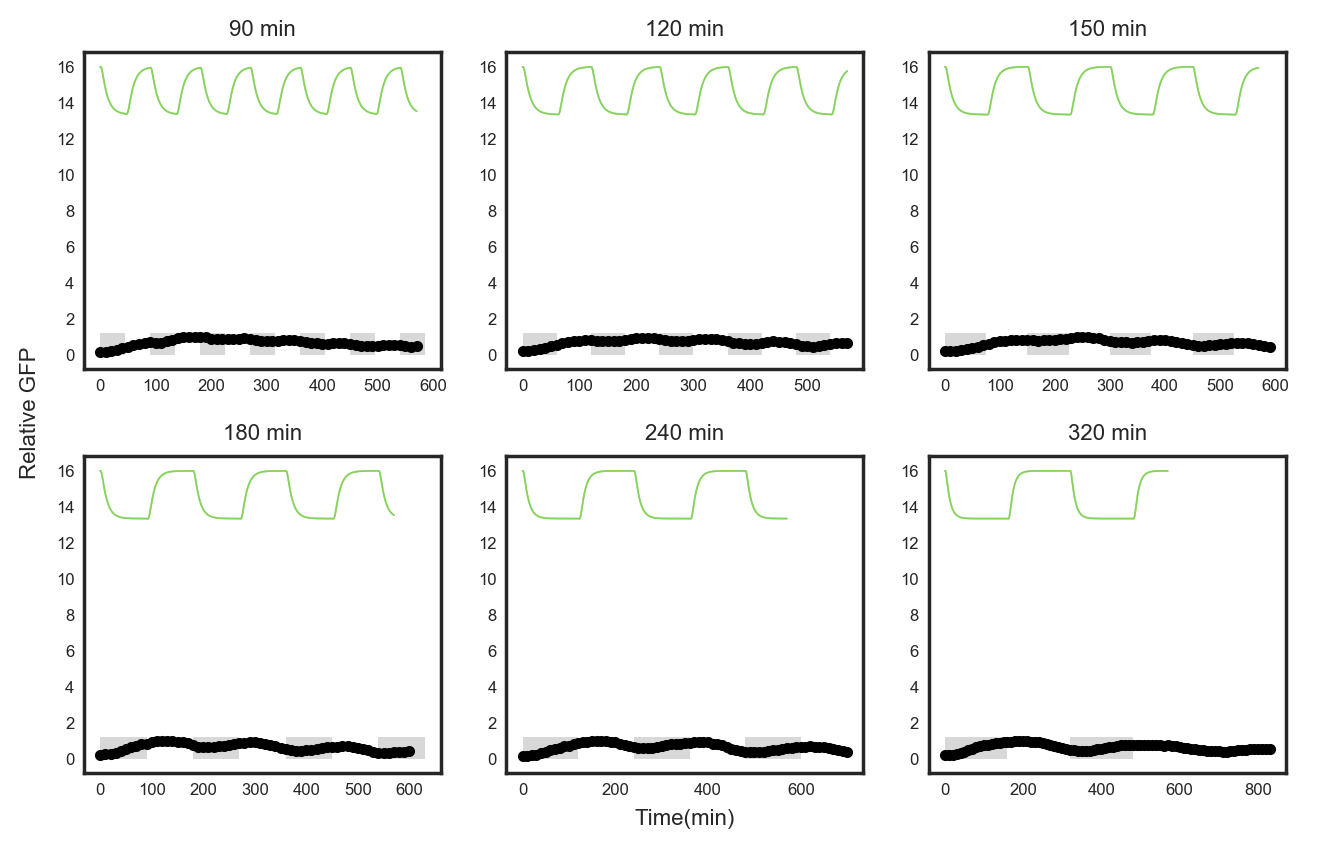

In [27]:
# Plot figure
fig = plt.figure(figsize=(6.85039, 4.5))
gs = gridspec.GridSpec(2,3)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])
D = fig.add_subplot(gs[1,0])
E = fig.add_subplot(gs[1,1])
F = fig.add_subplot(gs[1,2])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    for i in [90,120,150,180,240,320]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 90:
            A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 120: 
            B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 150: 
            C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 180:
            D.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 240:
            E.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 320: 
            F.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

scorefxn_time = periodic_time
scorefxn_data = periodic_data
A.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=3)
# A.axis([0, 570, 0, 1.2])
B.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=3)
# B.axis([0, 570, 0, 1.2])
C.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=3)
# C.axis([0, 570, 0, 1.2])
D.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=3)
# D.axis([0, 570, 0, 1.2])
E.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=3)
# E.axis([0, 570, 0, 1.2])
F.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=3)
# F.axis([0, 570, 0, 1.2])

for i in range(7):
    A.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(5):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(4):
    C.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(4):
    D.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(3):
    E.fill_between([i*240,i*240+120], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(2):
    F.fill_between([i*320,i*320+160], 0, 1.2, facecolor='gray', alpha=0.3)
    
ax.set_ylabel('Relative GFP')
ax.set_xlabel('Time(min)')

A.set_title('90 min')
B.set_title('120 min')
C.set_title('150 min')
D.set_title('180 min')
E.set_title('240 min')
F.set_title('320 min')

gs.tight_layout(fig)

plt.savefig('Figure 4.pdf',dpi=600)

# Figure S2

In [21]:
# Load more data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/broken_fb_constant.pickled'
with open(filename, 'rb') as f:
    Far1_arr = pickle.load(f)
BY103_time, BY103_data = Far1_arr

filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/Far1Constant.pickled'
with open(filename, 'rb') as f:
    Far1_arr = pickle.load(f)
Far1_time, Far1_data = Far1_arr

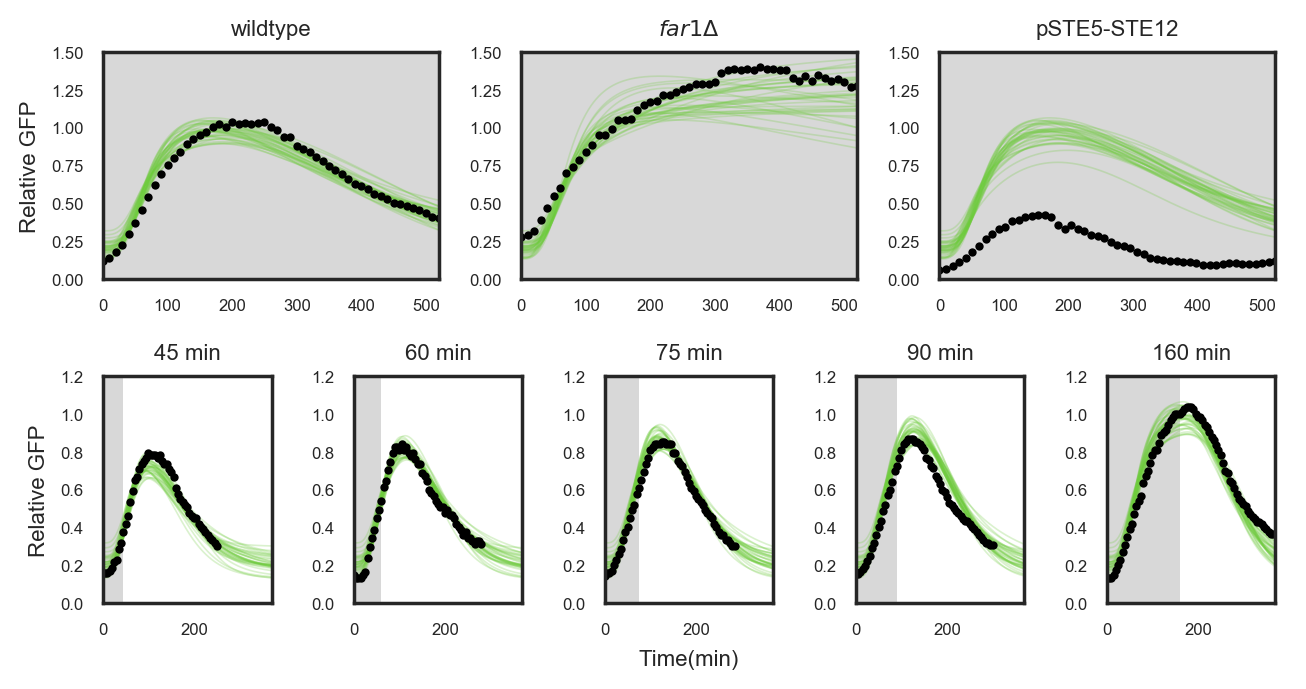

In [22]:
# Plot figure
fig = plt.figure(figsize=(6.85039, 3.75))
gs = gridspec.GridSpec(2,15)
A = fig.add_subplot(gs[1,0:3])
B = fig.add_subplot(gs[1,3:6])
C = fig.add_subplot(gs[1,6:9])
D = fig.add_subplot(gs[1,9:12])
E = fig.add_subplot(gs[1,12:15])
A1 = fig.add_subplot(gs[0,0:5])
B1 = fig.add_subplot(gs[0,5:10])
C1 = fig.add_subplot(gs[0,10:15])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    for i in [45,60,75,90,160]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 60: 
            B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 75: 
            C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 90:
            D.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 160:
            E.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    for i in [1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        A1.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    kfb_org = kfb2 
    kfb2 = 0
    inds = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
    expX = simulate_periodic_experiment(inds, time, i,SS[j])
    C1.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    kp4,ksynF1,ka5,kp3,kfb2 = [0,0,0,0,kfb_org]
    inds = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
    expX = simulate_periodic_experiment(inds, time, i,SS[j])
    B1.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

scorefxn_time = single_time
scorefxn_data = single_data
A.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=3)
A.axis([0, 370, 0, 1.2])
B.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=3)
B.axis([0, 370, 0, 1.2])
C.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=3)
C.axis([0, 370, 0, 1.2])
D.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=3)
D.axis([0, 370, 0, 1.2])
E.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=3)
E.axis([0, 370, 0, 1.2])
A1.plot(periodic_time[0], periodic_data[0], 'ko', markersize=3)
A1.axis([0, 520, 0, 1.5])
B1.plot(Far1_time, Far1_data, 'ko', markersize=3)
B1.axis([0, 520, 0, 1.5])
C1.plot(BY103_time, BY103_data, 'ko', markersize=3)
C1.axis([0, 520, 0, 1.5])

for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    E.fill_between([i*240,i*240+160], 0, 1.2, facecolor='gray', alpha=0.3)

A1.fill_between([0,570], 0, 1.5, facecolor='gray', alpha=0.3)
B1.fill_between([0,570], 0, 1.5, facecolor='gray', alpha=0.3)
C1.fill_between([0,570], 0, 1.5, facecolor='gray', alpha=0.3)
    
A.set_ylabel('Relative GFP')
ax.set_xlabel('Time(min)')
A1.set_ylabel('Relative GFP')

A.set_title('45 min')
B.set_title('60 min')
C.set_title('75 min')
D.set_title('90 min')
E.set_title('160 min')
A1.set_title('wildtype')
B1.set_title('$far1\Delta$')
C1.set_title('pSTE5-STE12')
gs.tight_layout(fig)

plt.savefig('Figure S2.pdf',dpi=600)

# Figure 5

In [30]:
# Import 10nM data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/10periodic.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
scorefxn_time_10, scorefxn_data_10 = syntheticdata

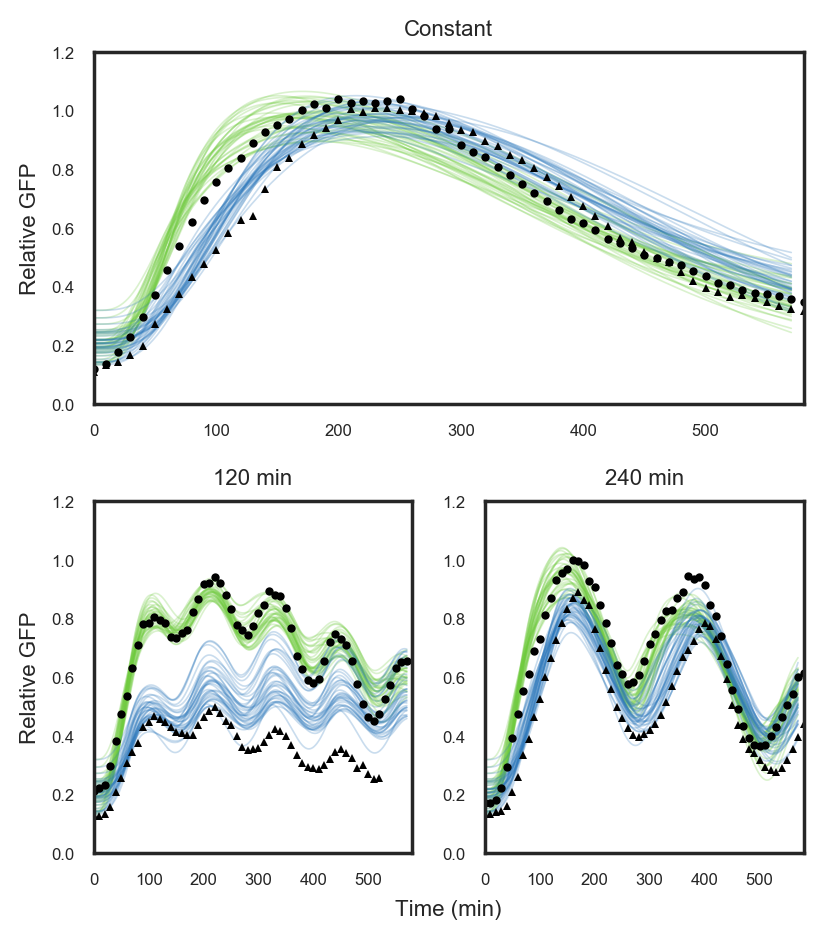

In [35]:
fig = plt.figure(figsize=(4.48819, 5))
gs = gridspec.GridSpec(2,2)
A = fig.add_subplot(gs[0,:])
B = fig.add_subplot(gs[1,0])
C = fig.add_subplot(gs[1,1])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#50nM
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    for i in [120,240]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 120:
            B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 240: 
            C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

#10nM
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    slope_on = slope_on*0.3
    params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    slope_on = slope_on*0.3
    params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
    for i in [120,240]:
        expX = simulate_periodic_experiment(params, time, i,SS[j])
        if i == 120:
            B.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)
        elif i == 240: 
            C.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)
    expX = simulate_periodic_experiment(params, time, 1,SS[j])
    A.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)

xmax = 580

scorefxn_time = scorefxn_time_10
scorefxn_data = scorefxn_data_10
B.plot(scorefxn_time[2], scorefxn_data[2], 'k^', markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[5], scorefxn_data[5], 'k^', markersize=3)
C.axis([0, xmax, 0, 1.2])
A.plot(scorefxn_time[0], scorefxn_data[0], 'k^', markersize=3)
A.axis([0, xmax, 0, 1.2])

scorefxn_time = periodic_time
scorefxn_data = periodic_data
B.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=3)
C.axis([0, xmax, 0, 1.2])
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=3)
A.axis([0, xmax, 0, 1.2])

A.set_ylabel('Relative GFP')
B.set_ylabel('Relative GFP')
ax.set_xlabel('Time (min)')

A.set_title('Constant')
B.set_title('120 min')
C.set_title('240 min')

fig.tight_layout()

plt.savefig('Figure 5.pdf',dpi=600)